In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [4]:
# 设置使用GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

加载MNIST数据集

In [5]:
train_transform = transforms.Compose([
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])
# 定义保存数据的目录
data_path = './data'

# 下载并加载MNIST训练集
train_dataset = datasets.MNIST(root=data_path, train=True, transform=train_transform, download=True)

# 下载并加载MNIST测试集
test_dataset = datasets.MNIST(root=data_path, train=False, transform=test_transform, download=True)

In [6]:
# 创建数据加载器
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

定义VAE

In [7]:
# 定义VAE模型
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        
        # 均值和方差的线性层
        self.fc_mean = nn.Linear(128, latent_dim)
        self.fc_var = nn.Linear(128, latent_dim)
        
        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = self.encoder(x)
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)
        return mean, log_var
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        z = mean + epsilon * std#利用这个将潜变量引入标准高斯分布的先验分布中
        return z
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mean, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mean, log_var)
        reconstructed = self.decode(z)
        return reconstructed, mean, log_var

In [22]:
import torch
import torch.nn.functional as F

def elbo_loss(target,reconstructed, mean, log_var):
    # 计算生成样本与原始样本的重建损失
    reconstruction_loss = F.binary_cross_entropy(reconstructed, target.view(-1, 784), reduction='sum')
    
    # 计算KL散度损失
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    
    # 将重建损失和KL散度损失相加得到ELBO损失
    elbo = (reconstruction_loss + kl_loss)/batch_size
    
    return elbo

In [23]:
model = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
from tqdm import tqdm

num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0
    data_loader = tqdm(train_loader, desc='Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, 0))
    for i, (images, _) in enumerate(data_loader, 0):
        optimizer.zero_grad()
        images = images.to(device)
        reconstructed, mean, log_var = model(images)
        
        
        loss =  elbo_loss(images,reconstructed, mean, log_var)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        data_loader.set_postfix(loss=total_loss / (i+1))
    
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, total_loss / len(train_loader)))

Epoch [1/50], Loss: 0.0000: 100%|██████████| 469/469 [00:08<00:00, 57.34it/s, loss=187] 


Epoch [1/50], Loss: 187.3077


Epoch [2/50], Loss: 0.0000: 100%|██████████| 469/469 [00:08<00:00, 58.20it/s, loss=160] 


Epoch [2/50], Loss: 159.9910


Epoch [3/50], Loss: 0.0000: 100%|██████████| 469/469 [00:08<00:00, 53.17it/s, loss=154] 


Epoch [3/50], Loss: 153.6601


Epoch [4/50], Loss: 0.0000: 100%|██████████| 469/469 [00:08<00:00, 58.25it/s, loss=150] 


Epoch [4/50], Loss: 150.0541


Epoch [5/50], Loss: 0.0000: 100%|██████████| 469/469 [00:08<00:00, 57.86it/s, loss=148] 


Epoch [5/50], Loss: 147.7869


Epoch [6/50], Loss: 0.0000: 100%|██████████| 469/469 [00:08<00:00, 58.25it/s, loss=146] 


Epoch [6/50], Loss: 146.2103


Epoch [7/50], Loss: 0.0000: 100%|██████████| 469/469 [00:08<00:00, 57.47it/s, loss=145] 


Epoch [7/50], Loss: 145.1624


Epoch [8/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 60.53it/s, loss=144] 


Epoch [8/50], Loss: 144.1605


Epoch [9/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 58.86it/s, loss=143] 


Epoch [9/50], Loss: 143.4521


Epoch [10/50], Loss: 0.0000: 100%|██████████| 469/469 [00:08<00:00, 58.23it/s, loss=143] 


Epoch [10/50], Loss: 142.8059


Epoch [11/50], Loss: 0.0000: 100%|██████████| 469/469 [00:08<00:00, 58.40it/s, loss=142] 


Epoch [11/50], Loss: 141.9840


Epoch [12/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 58.78it/s, loss=141] 


Epoch [12/50], Loss: 141.3776


Epoch [13/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 59.53it/s, loss=141] 


Epoch [13/50], Loss: 140.9863


Epoch [14/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 59.78it/s, loss=141] 


Epoch [14/50], Loss: 141.2103


Epoch [15/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 59.78it/s, loss=140] 


Epoch [15/50], Loss: 139.9834


Epoch [16/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 60.93it/s, loss=140] 


Epoch [16/50], Loss: 139.7855


Epoch [17/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 61.58it/s, loss=139] 


Epoch [17/50], Loss: 139.3614


Epoch [18/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 61.29it/s, loss=139] 


Epoch [18/50], Loss: 139.1352


Epoch [19/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 61.44it/s, loss=139] 


Epoch [19/50], Loss: 138.7040


Epoch [20/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 61.31it/s, loss=139] 


Epoch [20/50], Loss: 138.7324


Epoch [21/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 61.25it/s, loss=139] 


Epoch [21/50], Loss: 138.6428


Epoch [22/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 61.05it/s, loss=138] 


Epoch [22/50], Loss: 137.8568


Epoch [23/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 62.00it/s, loss=138] 


Epoch [23/50], Loss: 137.8090


Epoch [24/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 60.90it/s, loss=138] 


Epoch [24/50], Loss: 137.7208


Epoch [25/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 61.64it/s, loss=137] 


Epoch [25/50], Loss: 137.4967


Epoch [26/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 61.39it/s, loss=137] 


Epoch [26/50], Loss: 136.9263


Epoch [27/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 60.77it/s, loss=137] 


Epoch [27/50], Loss: 137.0667


Epoch [28/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 59.37it/s, loss=137] 


Epoch [28/50], Loss: 136.8762


Epoch [29/50], Loss: 0.0000: 100%|██████████| 469/469 [00:08<00:00, 57.09it/s, loss=137] 


Epoch [29/50], Loss: 136.7229


Epoch [30/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 59.69it/s, loss=137] 


Epoch [30/50], Loss: 136.8216


Epoch [31/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 60.46it/s, loss=137] 


Epoch [31/50], Loss: 136.5503


Epoch [32/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 60.19it/s, loss=136] 


Epoch [32/50], Loss: 136.1637


Epoch [33/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 59.20it/s, loss=136] 


Epoch [33/50], Loss: 135.9467


Epoch [34/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 58.92it/s, loss=136] 


Epoch [34/50], Loss: 136.0818


Epoch [35/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 60.60it/s, loss=136] 


Epoch [35/50], Loss: 135.6593


Epoch [36/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 60.36it/s, loss=136] 


Epoch [36/50], Loss: 135.5565


Epoch [37/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 58.82it/s, loss=136] 


Epoch [37/50], Loss: 135.5876


Epoch [38/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 59.90it/s, loss=135] 


Epoch [38/50], Loss: 135.2561


Epoch [39/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 60.17it/s, loss=135] 


Epoch [39/50], Loss: 135.1221


Epoch [40/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 60.18it/s, loss=135] 


Epoch [40/50], Loss: 134.9835


Epoch [41/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 60.38it/s, loss=135] 


Epoch [41/50], Loss: 134.9557


Epoch [42/50], Loss: 0.0000: 100%|██████████| 469/469 [00:07<00:00, 60.90it/s, loss=135] 


Epoch [42/50], Loss: 134.9177


Epoch [43/50], Loss: 0.0000: 100%|██████████| 469/469 [00:08<00:00, 58.26it/s, loss=135] 


Epoch [43/50], Loss: 134.9407


Epoch [44/50], Loss: 0.0000: 100%|██████████| 469/469 [00:08<00:00, 54.78it/s, loss=135] 


Epoch [44/50], Loss: 134.8891


Epoch [45/50], Loss: 0.0000: 100%|██████████| 469/469 [00:08<00:00, 55.73it/s, loss=134] 


Epoch [45/50], Loss: 134.4915


Epoch [46/50], Loss: 0.0000: 100%|██████████| 469/469 [00:08<00:00, 57.77it/s, loss=134] 


Epoch [46/50], Loss: 134.3943


Epoch [47/50], Loss: 0.0000: 100%|██████████| 469/469 [00:08<00:00, 57.53it/s, loss=134] 


Epoch [47/50], Loss: 134.1726


Epoch [48/50], Loss: 0.0000: 100%|██████████| 469/469 [00:09<00:00, 51.27it/s, loss=135] 


Epoch [48/50], Loss: 134.5483


Epoch [49/50], Loss: 0.0000: 100%|██████████| 469/469 [00:08<00:00, 57.87it/s, loss=134] 


Epoch [49/50], Loss: 134.3351


Epoch [50/50], Loss: 0.0000: 100%|██████████| 469/469 [00:08<00:00, 56.95it/s, loss=134] 

Epoch [50/50], Loss: 134.0348


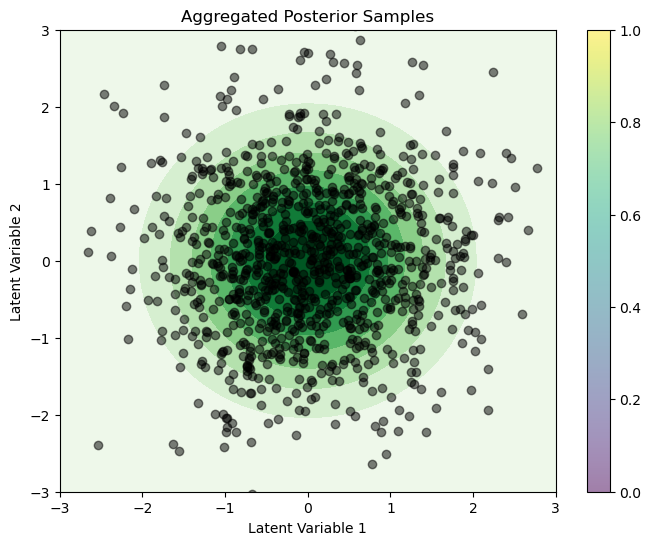

In [25]:
import matplotlib.pyplot as plt
import numpy as np
# 设置生成样本的数量
num_samples = 1000

# 生成潜变量z
with torch.no_grad():
    z = torch.randn(num_samples, 2).to(device)
    
# 解码器生成重建图像
reconstructed = model.decode(z)

# 获取标准高斯等高线数据
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = np.exp(-0.5 * (X**2 + Y**2)) / (2 * np.pi)

# 绘制图像
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, cmap='Greens')  # 标准高斯等高线填充颜色
plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), c='black', alpha=0.5)  # 聚合后验样本点
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('Aggregated Posterior Samples')
plt.colorbar()  # 添加颜色条
plt.show()

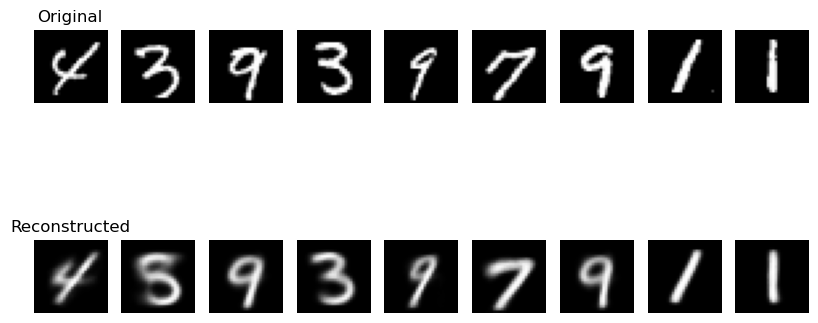

In [26]:
import torch
import torchvision
import matplotlib.pyplot as plt

# 设置模型为评估模式
model.eval()

# 随机选取测试集中的 9 个样本
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=9, shuffle=True)
original_images, _ = next(iter(test_loader))

# 将图像展平为一维向量
original_images = original_images.view(-1, 784).to(device)

# 使用模型进行重建
with torch.no_grad():
    reconstructed_images, _, _ = model(original_images)

# 将图像重新调整为 28x28 的形状
original_images = original_images.view(-1, 1, 28, 28).cpu().numpy()
reconstructed_images = reconstructed_images.view(-1, 1, 28, 28).cpu().numpy()

# 可视化原图和重建图像
plt.figure(figsize=(10, 5))
for i in range(9):
    # 原图
    plt.subplot(2, 9, i + 1)
    plt.imshow(original_images[i, 0], cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Original')

    # 重建图像
    plt.subplot(2, 9, i + 1 + 9)
    plt.imshow(reconstructed_images[i, 0], cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Reconstructed')

plt.show()


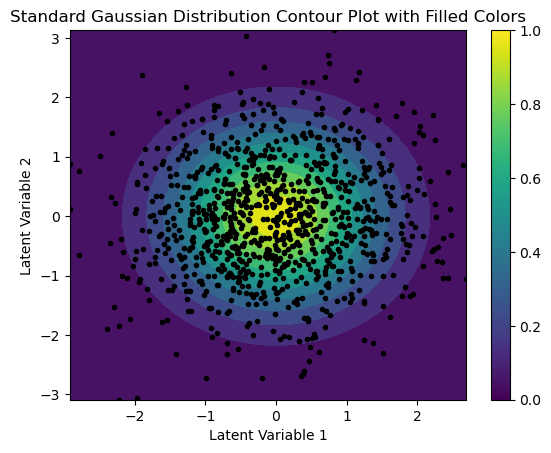

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# 设置模型为评估模式
model.eval()

# 从标准正态分布中采样潜在变量
num_samples = 1000
with torch.no_grad():
    z_samples = torch.randn(num_samples, 2).to(device)

# 获取潜在变量的范围
z_min, z_max = z_samples.min(dim=0)[0].cpu().numpy(), z_samples.max(dim=0)[0].cpu().numpy()

# 生成坐标点
x = np.linspace(z_min[0], z_max[0], 100)
y = np.linspace(z_min[1], z_max[1], 100)
x, y = np.meshgrid(x, y)
pos = np.dstack((x, y))

# 计算概率密度
mean = np.zeros(2)
covariance_matrix = np.eye(2)  # 协方差矩阵为单位矩阵
pdf = multivariate_normal(mean, covariance_matrix).pdf(pos)

# 绘制等高线图并填充颜色
plt.contourf(x, y, pdf, cmap='viridis', levels=10)
plt.scatter(z_samples[:, 0].cpu().numpy(), z_samples[:, 1].cpu().numpy(), color='black', marker='.')
plt.title('Standard Gaussian Distribution Contour Plot with Filled Colors')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.colorbar()  # 添加颜色条
plt.show()

In [23]:
torch.save(model,'./model/vae_stand.pth')

In [17]:
class VAE_1(nn.Module):
    def __init__(self, latent_dim=2, num_components=1):
        super(VAE_1, self).__init__()
        self.latent_dim = latent_dim
        self.num_components = num_components

        self.prior_weights = nn.Parameter(torch.ones(num_components)) # 混合模型每个分量的权重
        self.prior_mean = nn.Parameter(torch.zeros(num_components, latent_dim, 1))
        self.prior_var = nn.Parameter(torch.ones(num_components, latent_dim, 1))
        
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_components*latent_dim*2) # 每个分量的均值和对数方差，因此乘以2
        )
        
        self.fc_mean = nn.Linear(num_components*latent_dim*2, num_components*latent_dim)
        self.fc_var = nn.Linear(num_components*latent_dim*2, num_components*latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(num_components*latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, self.num_components, self.latent_dim*2) # 将输出分成每个分量的均值和对数方差
        prior_mean = self.prior_mean.unsqueeze(0).expand(x.size(0), -1, -1)
        prior_var = self.prior_var.unsqueeze(0).expand(x.size(0), -1, -1)

        mean = self.fc_mean(x[:, :, :self.latent_dim]) + prior_mean
        log_var = self.fc_var(x[:, :, self.latent_dim:]) + prior_var

        # mean = self.fc_mean(x[:, :, :self.latent_dim]) + self.prior_mean # 加上每个分量的先验均值
        # log_var = self.fc_var(x[:, :, self.latent_dim:]) + self.prior_var # 加上每个分量的先验方差
        return mean, log_var
    
    def reparameterize(self, mean, log_var):
        mean = mean.view(-1, self.num_components, self.latent_dim)
        log_var = log_var.view(-1, self.num_components, self.latent_dim)
        
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        z = mean + epsilon * std
        z = z.view(-1, self.num_components*self.latent_dim)
        return z
    
    def decode(self, z):
        z = z.view(-1, self.num_components, self.latent_dim)
        reconstructed = self.decoder(z)
        reconstructed = reconstructed.view(-1, 784)
        return reconstructed
    
    def forward(self, x):
        mean, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mean, log_var)
        reconstructed = self.decode(z)
        return reconstructed, mean, log_var


In [18]:
from tqdm import tqdm

model = VAE_1(latent_dim=2).to(device)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    data_loader = tqdm(train_loader, desc='Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, 0))
    for i, (images, _) in enumerate(data_loader, 0):
        optimizer.zero_grad()
        images = images.to(device)
        reconstructed, mean, log_var = model(images)
        

        
        loss = elbo_loss(images,reconstructed, mean, log_var)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        data_loader.set_postfix(loss=total_loss / (i+1))
    
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, total_loss / len(train_loader)))

Epoch [1/20], Loss: 0.0000:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.0000:   0%|          | 0/469 [00:04<?, ?it/s]


RuntimeError: expand(torch.cuda.FloatTensor{[1, 1, 2, 1]}, size=[128, -1, -1]): the number of sizes provided (3) must be greater or equal to the number of dimensions in the tensor (4)

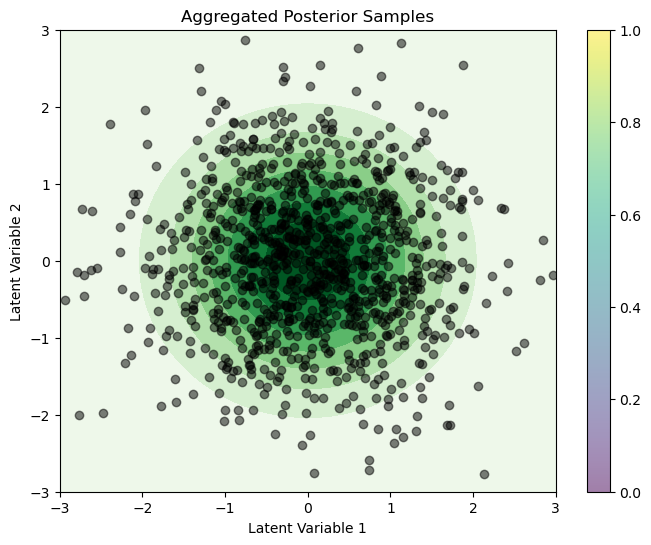

In [12]:
import matplotlib.pyplot as plt
import numpy as np
# 设置生成样本的数量
num_samples = 1000

# 生成潜变量z
with torch.no_grad():
    z = torch.randn(num_samples, 2).to(device)
    
# 解码器生成重建图像
reconstructed = model.decode(z)

# 获取标准高斯等高线数据
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = np.exp(-0.5 * (X**2 + Y**2)) / (2 * np.pi)

# 绘制图像
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, cmap='Greens')  # 标准高斯等高线填充颜色
plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), c='black', alpha=0.5)  # 聚合后验样本点
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('Aggregated Posterior Samples')
plt.colorbar()  # 添加颜色条
plt.show()

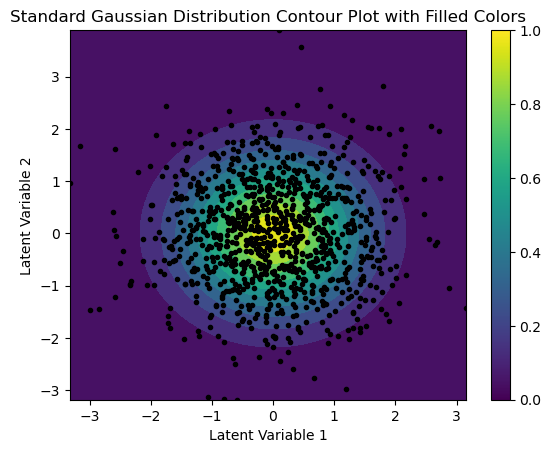

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# 设置模型为评估模式
model.eval()

# 从标准正态分布中采样潜在变量
num_samples = 1000
with torch.no_grad():
    z_samples = torch.randn(num_samples, 2).to(device)

# 获取潜在变量的范围
z_min, z_max = z_samples.min(dim=0)[0].cpu().numpy(), z_samples.max(dim=0)[0].cpu().numpy()

# 生成坐标点
x = np.linspace(z_min[0], z_max[0], 100)
y = np.linspace(z_min[1], z_max[1], 100)
x, y = np.meshgrid(x, y)
pos = np.dstack((x, y))

# 计算概率密度
mean = np.zeros(2)
covariance_matrix = np.eye(2)  # 协方差矩阵为单位矩阵
pdf = multivariate_normal(mean, covariance_matrix).pdf(pos)

# 绘制等高线图并填充颜色
plt.contourf(x, y, pdf, cmap='viridis', levels=10)
plt.scatter(z_samples[:, 0].cpu().numpy(), z_samples[:, 1].cpu().numpy(), color='black', marker='.')
plt.title('Standard Gaussian Distribution Contour Plot with Filled Colors')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.colorbar()  # 添加颜色条
plt.show()